  # scXpand Tutorial: Example of Data Preparation for Model Training and Optimization







  This tutorial demonstrates how to prepare paired scRNA/TCR-seq data as an input for model training and optimization.







  ## Example Dataset







  We use a publicly available paired scRNA/TCR-seq dataset of patients with brain tumors from:



  - **Study**: Wang et al. 2024



  - **Source**: https://zenodo.org/records/10672442


  - **Data type**: Paired scRNA/TCR-seq



  - **Cancer type**: Brain



  - **Tissue**: Tumor and Blood samples







  ## Tutorial Structure







  - **Data Loading and Initial Processing**



  - **Quality Control and Filtering**



  - **Data Preparation for scXpand**

## **Important note (!):**

This tutorial was made available to **examplify the process** we conducted to prepare the data as an input for model training, using just one dataset as an example.

It is highly recommended to directly use our pre-trained models rather than training them 'De-Novo' by yourselves.

---

## Data Loading and Initial Processing

### Loading scRNA-seq Data

In [1]:
# Import required libraries for data analysis, visualization, and single-cell processing
import os
import sys
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import seaborn as sns

# Set matplotlib backend for Jupyter notebooks
%matplotlib inline

# Plotting settings
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.axisbelow"] = True
sns.set_style("whitegrid")

# Setup project paths
project_root = Path.cwd().parent.parent
print(f"Project root: {project_root}")
sys.path.insert(0, str(project_root))

Project root: /Users/rona/repos/scXpand-1


In [2]:
# Download the brain tumor dataset from Zenodo and extract to demo directory
from scxpand.pretrained.download_manager import download_zenodo_dataset

demo_path = project_root / "data" / "demo"

# Automatically download data from Zenodo (record 10672442)
download_zenodo_dataset(
    zenodo_record_id="10672442", filename="Raw_files.zip", extract_dir=demo_path
)

source_path = demo_path / "Raw_files"

2025-10-26 09:10:17 [info     ] Downloading Zenodo dataset (record 10672442) to cache: /Users/rona/repos/scXpand-1/data/demo/.zenodo_cache [scxpand.pretrained.download_manager]
2025-10-26 09:10:17 [info     ] Dataset extracted to: /Users/rona/repos/scXpand-1/data/demo/Raw_files [scxpand.pretrained.download_manager]


In [3]:
# Identify all sample directories in the dataset (excluding files and 'Grex' folder)
samples = [
    s for s in os.listdir(source_path) if (source_path / s).is_dir() and s != "Grex"
]
print(f"Found {len(samples)} sample directories: {samples}")

Found 26 sample directories: ['GBM113_PBMC', 'GBM111Re_TIL', 'GBM074', 'GBM111Re_PBMC', 'GBM056', 'G4A062', 'G4A065Re', 'BrMet028', 'G4A112Re_TIL', 'BrMet010', 'GBM115', 'BrMet027', 'BrMet018', 'GBM114_PBMC', 'GBM105', 'BrMet009', 'GBM064', 'GBM063', 'GBM114_TIL', 'GBM091', 'GBM098', 'GBM106_PBMC', 'GBM106_TIL', 'GBM113_TIL', 'G4A112Re_PBMC', 'GBM104Re']


In [4]:
# Define helper function to load 10X data and initialize AnnData object with first sample
def load_sample_data(source_path: Path, sample: str) -> ad.AnnData:
    """Load and prepare 10X data for a single sample (optionally subset to first n_cells)."""
    adata = sc.read_10x_mtx(source_path / sample / "filtered_feature_bc_matrix")

    adata.obs["sample"] = sample
    adata.obs_names = [f"{name.split('-')[0]}_{sample}" for name in adata.obs_names]
    return adata


# Load first sample:
adata = load_sample_data(source_path, samples[0])
adata

AnnData object with n_obs × n_vars = 5259 × 33538
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [5]:
# Concatenate all remaining samples into a single AnnData object
for sample in samples[1:]:
    tmp = load_sample_data(source_path, sample)
    adata = ad.concat([adata, tmp])

In [6]:
# Ensure consistent gene metadata across all samples
adata.var = tmp.var.loc[adata.var_names]

In [7]:
# Display the combined dataset
adata

AnnData object with n_obs × n_vars = 110489 × 31915
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [8]:
# Mark mitochondrial genes for quality control
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [9]:
# Calculate quality control metrics including mitochondrial gene percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

... storing 'sample' as categorical
... storing 'feature_types' as categorical


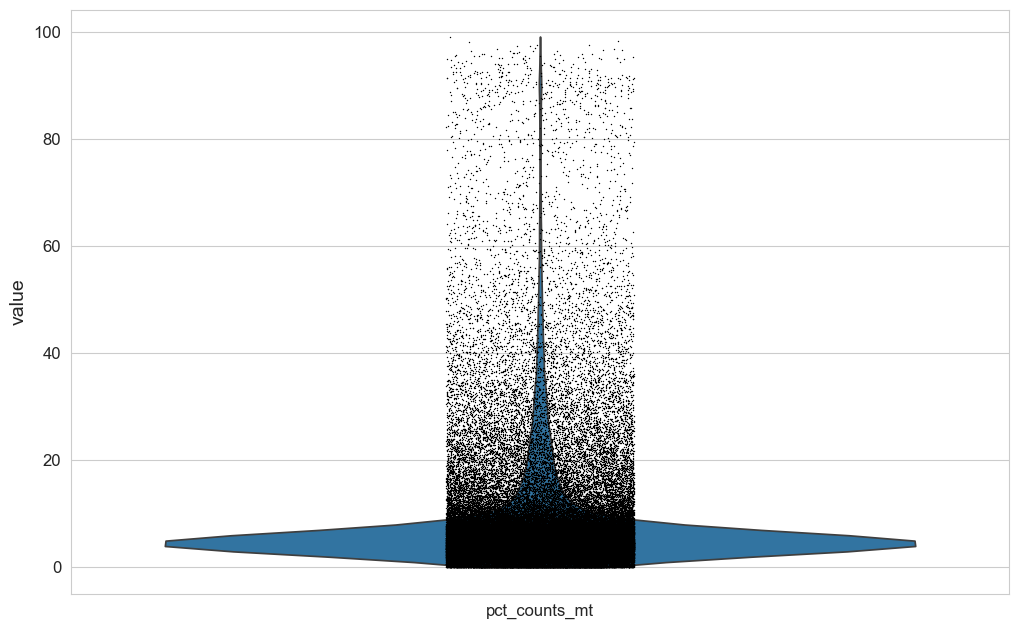

In [10]:
# Visualize distribution of mitochondrial gene percentage across cells
sc.pl.violin(adata, "pct_counts_mt", jitter=0.1)

In [11]:
# Filter cells with high mitochondrial content (<10%), low gene count, and rare genes
adata = adata[adata.obs.pct_counts_mt < 10, :]
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


AnnData object with n_obs × n_vars = 92033 × 23328
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [12]:
# Run Scrublet to detect doublets (two cells captured as one)
sc.pp.scrublet(adata, expected_doublet_rate=0.05, random_state=42)

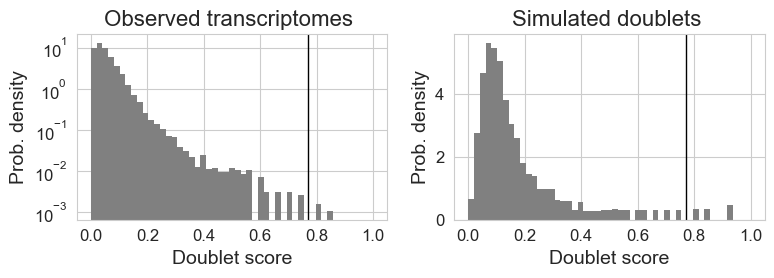

In [13]:
# Visualize doublet score distribution
sc.pl.scrublet_score_distribution(adata)

In [14]:
# Remove cells with high doublet scores (threshold = 0.3)
doublet_threshold = 0.3
adata = adata[adata.obs["doublet_score"] < doublet_threshold]
print(f"Remaining cells after doublet filtering: {adata.n_obs}")

Remaining cells after doublet filtering: 91545


In [15]:
# Store raw counts in a separate layer before normalization
adata.layers["counts"] = adata.X.copy()

/var/folders/gj/lml42yl53zj8xfsrl3r6dhr80000gn/T/ipykernel_10600/3142579704.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [16]:
# Assign tissue type based on sample name (PBMC = Blood, others = Tumor)
adata.obs["tissue_type"] = np.where(
    adata.obs["sample"].str.contains("PBMC"), "Blood", "Tumor"
)

---

## TCR-seq Data Processing

### Loading and Quality Control of TCR-seq Data

In [17]:
# Define helper function to load TCR-seq data and load first sample
def load_tcr_sample(source_path: Path, sample: str) -> ad.AnnData | None:
    """Load and prepare 10X VDJ data for a single sample (returns None if file doesn't exist)."""
    tcr_path = source_path / sample / "filtered_contig_annotations.csv"
    if not tcr_path.exists():
        return None
    adata_tcr = ir.io.read_10x_vdj(tcr_path)
    adata_tcr.obs_names = [
        f"{name.split('-')[0]}_{sample}" for name in adata_tcr.obs_names
    ]
    return adata_tcr


# Load first sample:
adata_tcr = load_tcr_sample(source_path, samples[0])
adata_tcr

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream
/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/anndata/utils.py:362: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


AnnData object with n_obs × n_vars = 1622 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

In [18]:
# Concatenate TCR data from all remaining samples
for sample in samples[1:]:
    tmp = load_tcr_sample(source_path, sample)
    if tmp is not None:
        adata_tcr = ad.concat([adata_tcr, tmp])

In [19]:
# Index TCR chains and perform quality control
ir.pp.index_chains(adata_tcr)
ir.tl.chain_qc(adata_tcr)

<Axes: title={'center': 'Number of cells in receptor_subtype by has_ir'}, xlabel='receptor_subtype', ylabel='Number of cells'>

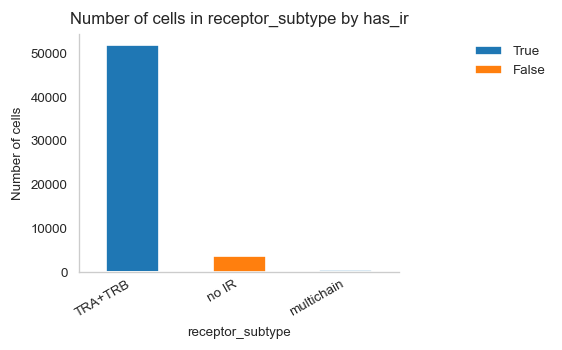

In [20]:
# Visualize abundance of different receptor subtypes (TCR, BCR, etc.)
ir.pl.group_abundance(adata_tcr, groupby="receptor_subtype")

In [21]:
# Display counts of cells per receptor subtype
adata_tcr.obs.groupby("receptor_subtype").size()

receptor_subtype
TRA+TRB       51779
multichain      406
no IR          3755
dtype: int64

In [22]:
# Calculate and display the fraction of cells with multiple TCR pairs
multichain_types = ["extra VJ", "extra VDJ", "two full chains", "multichain"]
multichain_fraction = adata_tcr.obs["chain_pairing"].isin(multichain_types).mean()
print(f"Fraction of cells with more than one pair of TCRs: {multichain_fraction:.2f}")

Fraction of cells with more than one pair of TCRs: 0.09


In [23]:
# Filter out cells with multichain TCRs (ambiguous pairing)
mu.pp.filter_obs(adata_tcr, "chain_pairing", lambda x: x != "multichain")
adata_tcr

AnnData object with n_obs × n_vars = 55534 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [24]:
# Remove cells with orphan chains (incomplete TCR pairs)
mu.pp.filter_obs(
    adata_tcr, "chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"])
)
adata_tcr

AnnData object with n_obs × n_vars = 42834 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [25]:
# Filter out cells with no immune receptor detected
adata_tcr = adata_tcr[adata_tcr.obs["receptor_subtype"] != "no IR"]
adata_tcr

View of AnnData object with n_obs × n_vars = 39079 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [26]:
# Calculate TCR sequence distance matrix for clonotype definition
ir.pp.ir_dist(adata_tcr)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scirpy/ir_dist/__init__.py:267: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  params.adata.uns[key_added] = result


In [27]:
# Define clonotypes (cells with identical TCR sequences)
ir.tl.define_clonotypes(adata_tcr, receptor_arms="all", dual_ir="primary_only")

In [28]:
# Keep only cells that have both scRNA-seq and TCR-seq data
adata = adata[adata.obs_names.isin(adata_tcr.obs_names)].copy()

---

## Cell Type Classification Using MAGIC Imputation

### Important Note

In our manuscript, MAGIC was applied on the integrated data using all single-cell studies together for better robustness, and not for each study separately. Here, we demonstrate the process on a single dataset for tutorial purposes.


### Processing Tumor Samples

First, we'll process the tumor-infiltrating T cells:

In [29]:
# Subset data to tumor samples only
adata_tumor = adata[adata.obs["tissue_type"] == "Tumor"]

In [30]:
# Normalize and log-transform tumor data (target sum = 10,000, log base 2)
sc.pp.normalize_total(adata_tumor, target_sum=1e4)
sc.pp.log1p(adata_tumor, base=2)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
# Apply MAGIC imputation to denoise and impute T cell marker genes
adata_magic_tumor = sc.external.pp.magic(
    adata_tumor,
    name_list=["CD8A", "CD8B", "CD4", "FOXP3", "CD3E", "PTPRC"],
    random_state=42,
)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


In [32]:
# Extract original (non-imputed) gene expression values
non_imputed_df = sc.get.obs_df(adata_tumor, list(adata_magic_tumor.var_names))

In [33]:
# Combine MAGIC-imputed and original expression values into one dataframe
magic_df_tumor = sc.get.obs_df(adata_magic_tumor, list(adata_magic_tumor.var_names))
magic_df_tumor.columns = [f"{col}_Imputed" for col in magic_df_tumor.columns]
magic_df_tumor = magic_df_tumor.join(non_imputed_df)

In [34]:
# Save tumor MAGIC labels to compressed CSV
magic_df_tumor.to_csv(
    source_path / "Brain_zenodo_MAGIC_labels_tumor.csv.gz", compression="gzip"
)

In [35]:
# Define function to classify T cells as CD8, CD4, Double Positive, or Double Negative
def classify_cell_type(is_cd8a: bool, is_cd8b: bool, is_cd4: bool) -> str:
    """Classify as CD8/CD4/Double_Positive/Double_Negative based on marker expression."""
    has_cd8 = is_cd8a | is_cd8b
    if has_cd8 & ~is_cd4:
        return "is_CD8"
    elif ~has_cd8 & is_cd4:
        return "is_CD4"
    elif has_cd8 & is_cd4:
        return "Double_Positive"
    else:
        return "Double_Negative"

In [36]:
# Define function to reconcile original and MAGIC-imputed cell type classifications
def reconcile_cell_types(original: str, magic: str) -> str:
    """
    Reconcile original and MAGIC classifications using priority rules:
    - Double_Positive takes precedence
    - Original CD8/CD4 retained if MAGIC agrees or is Double_Negative
    - MAGIC result used if original is Double_Negative
    """
    if original == "Double_Positive":
        return "Double_Positive"
    elif original == "is_CD8" and magic in ["is_CD4", "Double_Negative", "is_CD8"]:
        return "is_CD8"
    elif original == "is_CD4" and magic in ["is_CD4", "Double_Negative", "is_CD8"]:
        return "is_CD4"
    elif original in ["is_CD4", "is_CD8"] and magic == "Double_Positive":
        return "Double_Positive"
    elif original == "Double_Negative":
        return magic
    return original

In [37]:
# Define function to identify regulatory T cells (Treg) based on FOXP3 expression
def identify_treg_cells(row: pd.Series) -> str:
    """Mark CD4+ cells with FOXP3 > 1 as Treg."""
    if row["final_type"] == "is_CD4" and (row["FOXP3"] > 1 or row["FOXP3_Imputed"] > 1):
        return "is_Treg"
    return row["final_type"]

In [38]:
# Define complete vectorized pipeline for cell type classification with cutoffs
def classify_tissue_cells(
    df: pd.DataFrame, cd8a_cutoff: float, cd8b_cutoff: float, cd4_cutoff: float
) -> pd.DataFrame:
    """
    Complete classification pipeline using vectorized operations:
    1. Classify based on imputed expression (MAGIC)
    2. Classify based on original expression
    3. Reconcile both classifications
    4. Identify Treg cells
    """
    # Vectorized classification based on imputed expression:
    is_cd8a_imp = df["CD8A_Imputed"] > cd8a_cutoff
    is_cd8b_imp = df["CD8B_Imputed"] > cd8b_cutoff
    is_cd4_imp = df["CD4_Imputed"] > cd4_cutoff
    has_cd8_imp = is_cd8a_imp | is_cd8b_imp

    # Initialize and assign MAGIC cell types:
    df["MAGIC_Cell_Type"] = "Double_Negative"
    df.loc[has_cd8_imp & ~is_cd4_imp, "MAGIC_Cell_Type"] = "is_CD8"
    df.loc[~has_cd8_imp & is_cd4_imp, "MAGIC_Cell_Type"] = "is_CD4"
    df.loc[has_cd8_imp & is_cd4_imp, "MAGIC_Cell_Type"] = "Double_Positive"

    # Vectorized classification based on original expression:
    is_cd8a_orig = df["CD8A"] > 1
    is_cd8b_orig = df["CD8B"] > 1
    is_cd4_orig = df["CD4"] > 1
    has_cd8_orig = is_cd8a_orig | is_cd8b_orig

    # Initialize and assign original cell types:
    df["type_original"] = "Double_Negative"
    df.loc[has_cd8_orig & ~is_cd4_orig, "type_original"] = "is_CD8"
    df.loc[~has_cd8_orig & is_cd4_orig, "type_original"] = "is_CD4"
    df.loc[has_cd8_orig & is_cd4_orig, "type_original"] = "Double_Positive"

    # Vectorized reconciliation of classifications:
    df["final_type"] = df["type_original"].copy()

    # Apply reconciliation rules using boolean masks:
    cd8_mask = (df["type_original"] == "is_CD8") & df["MAGIC_Cell_Type"].isin(
        ["is_CD4", "Double_Negative", "is_CD8"]
    )
    df.loc[cd8_mask, "final_type"] = "is_CD8"

    cd4_mask = (df["type_original"] == "is_CD4") & df["MAGIC_Cell_Type"].isin(
        ["is_CD4", "Double_Negative", "is_CD8"]
    )
    df.loc[cd4_mask, "final_type"] = "is_CD4"

    double_pos_mask = df["type_original"].isin(["is_CD4", "is_CD8"]) & (
        df["MAGIC_Cell_Type"] == "Double_Positive"
    )
    df.loc[double_pos_mask, "final_type"] = "Double_Positive"

    double_neg_mask = df["type_original"] == "Double_Negative"
    df.loc[double_neg_mask, "final_type"] = df.loc[double_neg_mask, "MAGIC_Cell_Type"]

    # Vectorized Treg identification:
    treg_mask = (df["final_type"] == "is_CD4") & (
        (df["FOXP3"] > 1) | (df["FOXP3_Imputed"] > 1)
    )
    df.loc[treg_mask, "final_type"] = "is_Treg"

    return df

In [39]:
# Save tumor MAGIC labels again (redundant save - cell 41 already saves this)
magic_df_tumor.to_csv(
    os.path.join(source_path, "Brain_zenodo_MAGIC_labels_tumor.csv.gz"),
    compression="gzip",
)

In [40]:
# Define function to plot gene expression density and determine cutoff threshold
def plot_expression_density_with_cutoff(
    data: pd.DataFrame, gene_name: str, clip_range: list[float] | None = None, ax=None
) -> float:
    """Plot expression density and return cutoff value at minimum density (trough)."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Find cutoff at trough
    if clip_range:
        sns.kdeplot(data[gene_name], clip=clip_range, ax=ax)
    else:
        sns.kdeplot(data[gene_name], ax=ax)

    line = ax.lines[0]
    x, y = line.get_data()
    min_idx = np.argmin(y)
    cutoff_x = x[min_idx]
    cutoff_y = y[min_idx]

    ax.axvline(x=cutoff_x, color="r", linestyle="--", lw=2)
    ax.axhline(y=cutoff_y, color="r", linestyle="--", lw=2)
    ax.set_title(f"{gene_name} - Cutoff: {cutoff_x:.4f}")
    ax.set_xlabel("Gene Expression")
    ax.set_ylabel("Density")

    return cutoff_x


def plot_cutoffs_for_tissue(data: pd.DataFrame, tissue_name: str, genes_dict: dict):
    """Plot expression density and cutoffs for multiple genes in subplots."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{tissue_name} - Gene Expression Cutoffs", fontsize=14, y=1.02)

    cutoffs = {}
    for idx, (gene, clip_range) in enumerate(genes_dict.items()):
        cutoff = plot_expression_density_with_cutoff(
            data, gene, clip_range, ax=axes[idx]
        )
        cutoffs[gene] = cutoff

    plt.tight_layout()
    plt.show()

    return cutoffs

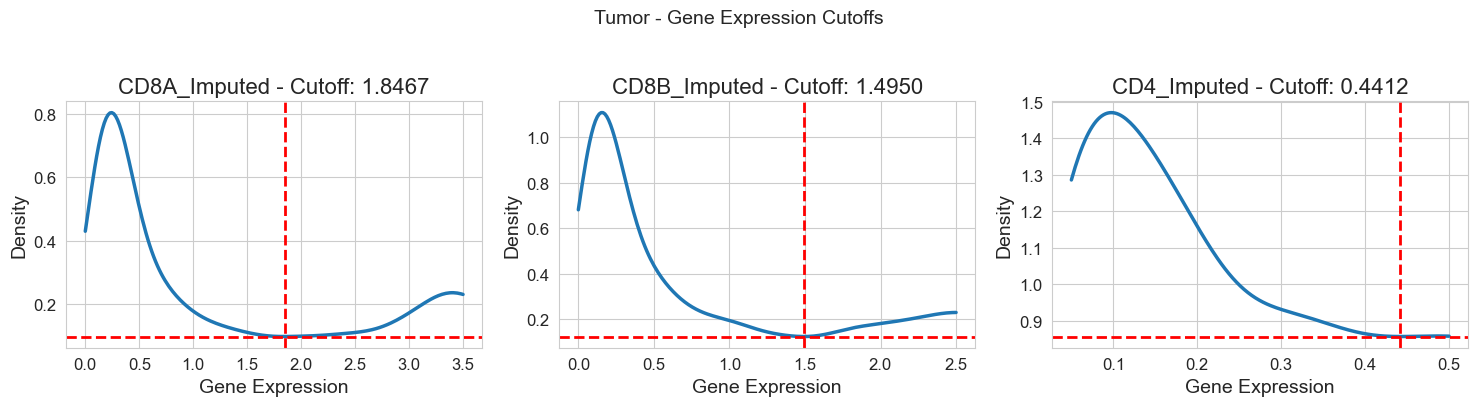

In [41]:
# Determine optimal expression cutoffs for CD8A, CD8B, and CD4 in tumor samples
tumor_genes = {
    "CD8A_Imputed": [0, 3.5],
    "CD8B_Imputed": [0, 2.5],
    "CD4_Imputed": [0.05, 0.5],
}

cutoffs_tumor = plot_cutoffs_for_tissue(magic_df_tumor, "Tumor", tumor_genes)
cd8a_cutoff_tumor = cutoffs_tumor["CD8A_Imputed"]
cd8b_cutoff_tumor = cutoffs_tumor["CD8B_Imputed"]
cd4_cutoff_tumor = cutoffs_tumor["CD4_Imputed"]

In [42]:
# Apply cell type classification to tumor samples using determined cutoffs
magic_df_tumor = classify_tissue_cells(
    magic_df_tumor,
    cd8a_cutoff=cd8a_cutoff_tumor,
    cd8b_cutoff=cd8b_cutoff_tumor,
    cd4_cutoff=cd4_cutoff_tumor,
)

In [43]:
# Save final classified tumor labels to compressed CSV
magic_df_tumor.to_csv(
    source_path / "Brain_zenodo_final_tumor_MAGIC_labels.csv.gz", compression="gzip"
)

---

### Processing Blood (PBMC) Samples

Now we'll apply the same process to peripheral blood mononuclear cells:

In [44]:
# Subset data to blood (PBMC) samples only
adata_blood = adata[adata.obs["tissue_type"] == "Blood"]

In [45]:
# Normalize and log-transform blood data (target sum = 10,000, log base 2)
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood, base=2)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [46]:
# Apply MAGIC imputation to denoise and impute T cell marker genes in blood
adata_magic_blood = sc.external.pp.magic(
    adata_blood,
    name_list=["CD8A", "CD8B", "CD4", "FOXP3", "CD3E", "PTPRC"],
    random_state=42,
)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


In [47]:
# Combine MAGIC-imputed and original expression values for blood samples
non_imputed_df = sc.get.obs_df(adata_blood, list(adata_magic_blood.var_names))
magic_df_blood = sc.get.obs_df(adata_magic_blood, list(adata_magic_blood.var_names))
magic_df_blood.columns = [f"{col}_Imputed" for col in magic_df_blood.columns]
magic_df_blood = magic_df_blood.join(non_imputed_df)

In [48]:
# Save blood MAGIC labels to compressed CSV
magic_df_blood.to_csv(
    source_path / "Brain_zenodo_MAGIC_labels_blood.csv.gz", compression="gzip"
)

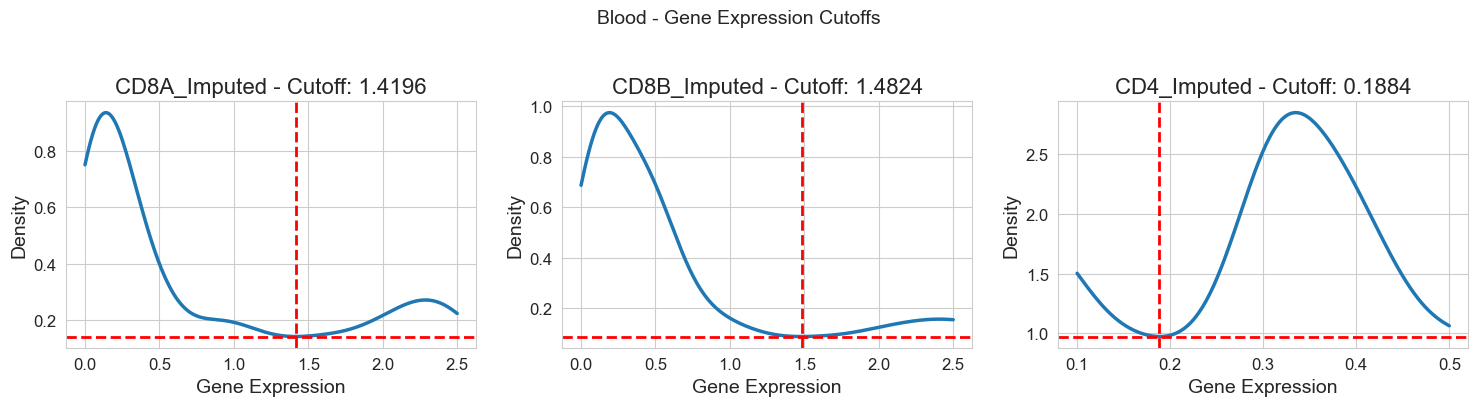

In [49]:
# Determine optimal expression cutoffs for CD8A, CD8B, and CD4 in blood samples
blood_genes = {
    "CD8A_Imputed": [0, 2.5],
    "CD8B_Imputed": [0, 2.5],
    "CD4_Imputed": [0.1, 0.5],
}

cutoffs_blood = plot_cutoffs_for_tissue(magic_df_blood, "Blood", blood_genes)
cd8a_cutoff_blood = cutoffs_blood["CD8A_Imputed"]
cd8b_cutoff_blood = cutoffs_blood["CD8B_Imputed"]
cd4_cutoff_blood = cutoffs_blood["CD4_Imputed"]

In [50]:
# Apply cell type classification to blood samples using determined cutoffs
magic_df_blood = classify_tissue_cells(
    magic_df_blood,
    cd8a_cutoff=cd8a_cutoff_blood,
    cd8b_cutoff=cd8b_cutoff_blood,
    cd4_cutoff=cd4_cutoff_blood,
)

In [51]:
# Save final classified blood labels to compressed CSV
magic_df_blood.to_csv(
    source_path / "Brain_zenodo_final_blood_MAGIC_labels.csv.gz", compression="gzip"
)

In [52]:
# Add TCR clonotype and receptor type information to the main AnnData object
adata.obs["clone_id"] = adata_tcr.obs["clone_id"]
adata.obs["receptor_type"] = adata_tcr.obs["receptor_type"]

In [53]:
# Add study metadata: cancer type and publication reference
adata.obs["cancer_type"] = "Brain Tumors"
adata.obs["study"] = "Wang et al. 2024 (Brain)"

In [54]:
# Combine tumor and blood cell type classifications
magic_labels = pd.concat([magic_df_tumor, magic_df_blood])

In [55]:
# Add final cell type labels to the main AnnData object
adata.obs["imputed_labels"] = magic_labels["final_type"]

In [56]:
# Extract patient ID from sample names and ensure string types
adata.obs["patient"] = adata.obs["sample"].str.split("_").str[0]
adata.obs["sample"] = adata.obs["sample"].astype(str)
adata.obs["tissue_type"] = adata.obs["tissue_type"].astype(str)

In [57]:
# Create unique clone IDs incorporating patient, clonotype, and cell type; calculate clone sizes
adata.obs["clone_id"] = (
    adata.obs["patient"].astype(str)
    + "_"
    + adata.obs["clone_id"].astype(str)
    + "_"
    + adata.obs["imputed_labels"].astype(str)
)
adata.obs["clone_id_size"] = adata.obs.groupby(["sample", "clone_id"]).transform("size")

In [58]:
# Classify clones as expanded or non-expanded using Shiao et al. criteria (>1.5x median)
# Calculate median clone size per sample
clone_sizes = (
    adata[adata.obs["clone_id_size"] > 1]
    .obs.groupby(["sample", "clone_id"])
    .size()
    .reset_index(name="clone_size")[["sample", "clone_size"]]
)
median_clone_sizes = clone_sizes.groupby("sample").median()
median_clone_sizes["1.5x_median"] = median_clone_sizes["clone_size"] * 1.5
median_clone_sizes = median_clone_sizes.reset_index()

# Merge back to adata
tmp = (
    adata.obs.reset_index()
    .merge(median_clone_sizes, on="sample", how="left")
    .set_index("index")
)
adata.obs["median_clone_size"] = tmp["clone_size"]
adata.obs["1.5x_median_clone_size"] = tmp["1.5x_median"]

# Vectorized expansion classification:
adata.obs["expansion"] = np.where(
    adata.obs["1.5x_median_clone_size"] < adata.obs["clone_id_size"],
    "expanded",
    "non_expanded",
)

In [59]:
# Display counts of expanded vs non-expanded cells by tissue type and sample
adata.obs.groupby(["tissue_type", "sample", "expansion"]).size()

tissue_type  sample         expansion   
Blood        G4A112Re_PBMC  expanded         348
                            non_expanded     791
             GBM106_PBMC    expanded         278
                            non_expanded    2705
             GBM111Re_PBMC  expanded          30
                            non_expanded     563
             GBM113_PBMC    expanded         389
                            non_expanded     615
             GBM114_PBMC    expanded          49
                            non_expanded     348
Tumor        BrMet009       expanded         622
                            non_expanded     402
             BrMet010       expanded         227
                            non_expanded     684
             BrMet018       expanded         237
                            non_expanded    1354
             BrMet027       expanded         740
                            non_expanded    2184
             BrMet028       expanded         131
                            

In [60]:
# Reorganize gene metadata to use gene IDs as index with gene names as column
adata.var = adata.var.rename_axis("gene_name").reset_index().set_index("gene_ids")

In [61]:
# Save the fully processed AnnData object (commented out - uncomment to save)
# adata.write(os.path.join(source_path, "scXpand_preprocessed_data_Brain_zenodo.h5ad"), compression = 'gzip')